<a href="https://colab.research.google.com/github/saran2811/medRAG/blob/main/Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 40.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.6
    Uninstalling transformers-4.57.6:
      Successfully uninstalled transformers-4.57.6


## Local Inference on GPU
Model page: https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe(messages)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': "Greetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have.\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have."}]}]

In [ ]:
messages = [
    {"role": "user", "content": "Can you state all planets in our solar system in single line 20 words.No explanations or thoughts direct answer please"},
]
pipe(messages)

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': [{'role': 'user',
    'content': 'Can you state all planets in our solar system in single line 20 words.No explanations or thoughts direct answer please'},
   {'role': 'assistant',
    'content': "Alright, I need to list all the planets in our solar system in a single line that's 20 words. Let me think about how to approach this.\n\nFirst, I should recall all the planets. There are eight in total: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune. I should write them in order, probably starting from the innermost to the outermost.\n\nI need to make sure they're in the correct sequence. Mercury is the first, then Venus, Earth, Mars. Then comes Jupiter, Saturn, Uranus, and Neptune. Let me count them: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune. That's eight, which is correct.\n\nNow, I should combine them into a single line. Maybe start with Mercury, then list them in order with commas separating each. Let me see: Mercury, Venus, Eart

In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes trl sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 44.7 MB/s eta 0:00:00


In [ ]:
import json, random

paths = {
    "us": "/content/train_us.jsonl",
    "china": "/content/train_mainland.jsonl",
    "taiwan": "/content/train_taiwan.jsonl"
}

def load_jsonl(p):
    data=[]
    with open(p,"r",encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

us = load_jsonl(paths["us"])
cn = load_jsonl(paths["china"])
tw = load_jsonl(paths["taiwan"])

print("US:",len(us),"CN:",len(cn),"TW:",len(tw))


def convert(data, lang):
    out=[]
    for x in data:
        q = x.get("question","").strip()
        a = x.get("answer","").strip()

        if len(q)<10 or len(a)<5:
            continue

        inst = "Answer the medical question." if lang=="en" else "回答以下醫學問題。"

        out.append({
            "instruction": inst,
            "input": q,
            "output": a,
            "lang": lang
        })
    return out


us_f = convert(us,"en")
cn_f = convert(cn,"zh-cn")
tw_f = convert(tw,"zh-tw")

min_len = min(len(us_f),len(cn_f),len(tw_f)) #balancing

us_f = random.sample(us_f,min_len)
cn_f = random.sample(cn_f,min_len)
tw_f = random.sample(tw_f,min_len)

merged = us_f + cn_f + tw_f
random.shuffle(merged)

with open("/content/merged_train.jsonl","w",encoding="utf-8") as f:
    for r in merged:
        f.write(json.dumps(r,ensure_ascii=False)+"\n")

print("Final samples:",len(merged))


US: 10178 CN: 27400 TW: 11298
Final samples: 29982


In [ ]:
TARGET_TOTAL = 8000
PER_LANG = TARGET_TOTAL // 3   # ≈ 2666

print("Sampling per language:", PER_LANG)

us_f_small = random.sample(us_f, PER_LANG)
cn_f_small = random.sample(cn_f, PER_LANG)
tw_f_small = random.sample(tw_f, PER_LANG)

merged = us_f_small + cn_f_small + tw_f_small
random.shuffle(merged)

with open("/content/merged_train_8k.jsonl","w",encoding="utf-8") as f:
    for r in merged:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Final balanced samples:", len(merged))


Sampling per language: 2666
Final balanced samples: 7998


In [ ]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="/content/merged_train_8k.jsonl")
print(dataset)


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'lang'],
        num_rows: 7998
    })
})


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)


Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

In [ ]:
def tokenize(batch):
    texts = []

    for inst, ques, ans in zip(
        batch["instruction"],
        batch["input"],
        batch["output"]
    ):
        prompt = f"""
### Instruction:
{inst}

### Question:
{ques}

### Answer:
{ans}
"""
        texts.append(prompt)

    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=768
    )


tokenized = dataset["train"].map(
    tokenize,
    batched=True,
    remove_columns=dataset["train"].column_names
)


Map:   0%|          | 0/7998 [00:00<?, ? examples/s]

In [ ]:
tokenized = tokenized.map(
    lambda x: {"labels": x["input_ids"]},
    batched=True
)


Map:   0%|          | 0/7998 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/deepseek-medqa",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",
    remove_unused_columns=False
)


In [ ]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()


trainable params: 2,179,072 || all params: 1,779,267,072 || trainable%: 0.1225


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
50,2.346616
100,0.425344
150,0.405491
200,0.405122
250,0.377975
300,0.380738
350,0.367814
400,0.366899
450,0.387850
500,0.388499


TrainOutput(global_step=2000, training_loss=0.40667520809173585, metrics={'train_runtime': 5858.3404, 'train_samples_per_second': 1.365, 'train_steps_per_second': 0.341, 'total_flos': 5.697356645951078e+16, 'train_loss': 0.40667520809173585, 'epoch': 1.0})

In [ ]:
model.save_pretrained("/content/deepseek-medqa-lora")
tokenizer.save_pretrained("/content/deepseek-medqa-lora")


('/content/deepseek-medqa-lora/tokenizer_config.json',
 '/content/deepseek-medqa-lora/chat_template.jinja',
 '/content/deepseek-medqa-lora/tokenizer.json')

In [ ]:
!zip -r deepseek-medqa-lora.zip /content/deepseek-medqa-lora


  adding: content/deepseek-medqa-lora/ (stored 0%)
  adding: content/deepseek-medqa-lora/README.md (deflated 66%)
  adding: content/deepseek-medqa-lora/adapter_model.safetensors (deflated 8%)
  adding: content/deepseek-medqa-lora/tokenizer_config.json (deflated 45%)
  adding: content/deepseek-medqa-lora/adapter_config.json (deflated 58%)
  adding: content/deepseek-medqa-lora/chat_template.jinja (deflated 75%)
  adding: content/deepseek-medqa-lora/tokenizer.json (deflated 81%)


In [ ]:
from google.colab import files
files.download("/content/deepseek-medqa-lora.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/deepseek-medqa-lora")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip uninstall -y sentence-transformers


Found existing installation: sentence-transformers 5.2.2
Uninstalling sentence-transformers-5.2.2:
  Successfully uninstalled sentence-transformers-5.2.2


Testing evaluation

In [ ]:
!pip install -q transformers peft accelerate bitsandbytes datasets sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
!unzip deepseek-medqa-lora.zip -d /content/


Archive:  deepseek-medqa-lora.zip
   creating: /content/content/deepseek-medqa-lora/
  inflating: /content/content/deepseek-medqa-lora/README.md  
  inflating: /content/content/deepseek-medqa-lora/adapter_model.safetensors  
  inflating: /content/content/deepseek-medqa-lora/tokenizer_config.json  
  inflating: /content/content/deepseek-medqa-lora/adapter_config.json  
  inflating: /content/content/deepseek-medqa-lora/chat_template.jinja  
  inflating: /content/content/deepseek-medqa-lora/tokenizer.json  


In [ ]:
import json

test_paths = {
    "us": "/content/CH/test.jsonl",
    "china": "/content/CH/test.jsonl",
    "taiwan": "/content/TH/test.jsonl"
}

def load_jsonl(p):
    data = []
    with open(p, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

test_us = load_jsonl(test_paths["us"])
test_cn = load_jsonl(test_paths["china"])
test_tw = load_jsonl(test_paths.get("taiwan","")) if "taiwan" in test_paths else []

print(len(test_us), len(test_cn), len(test_tw))


3426 3426 1413


In [ ]:
def convert_test(data, lang):
    out = []
    for x in data:
        q = x.get("question","").strip()
        a = x.get("answer","").strip()

        if len(q) < 10 or len(a) < 5:
            continue

        inst = "Answer the medical question." if lang == "en" else "回答以下醫學問題。"

        out.append({  "instruction": inst,"input": q, "output": a,"lang": lang
        })
    return out

test_en = convert_test(test_us, "en")
test_cn = convert_test(test_cn, "zh-cn")
test_tw = convert_test(test_tw, "zh-tw")


In [ ]:
test_merged = test_en + test_cn + test_tw

with open("/content/merged_test.jsonl", "w", encoding="utf-8") as f:
    for r in test_merged:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Total test samples:", len(test_merged))


Total test samples: 5911


In [ ]:
from datasets import load_dataset

test_dataset = load_dataset(
    "json",
    data_files="/content/merged_test.jsonl"
)["train"]


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
def tokenize_eval(batch):
    texts = []
    for inst, ques, ans in zip(
        batch["instruction"],
        batch["input"],
        batch["output"]
    ):
        prompt = f"""
### Instruction:
{inst}

### Question:
{ques}

### Answer:
{ans}
"""
        texts.append(prompt)

    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=768
    )

tokenized_test = test_dataset.map(
    tokenize_eval,
    batched=True,
    remove_columns=test_dataset.column_names
)

tokenized_test = tokenized_test.map(
    lambda x: {"labels": x["input_ids"]},
    batched=True
)


Map:   0%|          | 0/5911 [00:00<?, ? examples/s]

Map:   0%|          | 0/5911 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
from peft import PeftModel

finetuned_model = PeftModel.from_pretrained(
    base_model,
    "/content/content/deepseek-medqa-lora",
    is_trainable=False
)

finetuned_model.eval()


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:598: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.2.self_attn.v_proj.l

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Line

In [ ]:
from transformers import TrainingArguments

eval_args = TrainingArguments(
    output_dir="/content/eval",
    per_device_eval_batch_size=1,
    fp16=True,
    report_to="none"
)


In [ ]:
from transformers import AutoModelForCausalLM

base_model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

base_model.eval()


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotar

In [ ]:
from transformers import Trainer
import math

base_trainer = Trainer(
    model=base_model,
    args=eval_args,
    eval_dataset=tokenized_test
)

base_metrics = base_trainer.evaluate()
base_loss = base_metrics["eval_loss"]
base_ppl = math.exp(base_loss)

print("Base Model Loss:", base_loss)
print("Base Model Perplexity:", base_ppl)


Base Model Loss: 10.950580596923828
Base Model Perplexity: 56987.12231101804


In [ ]:
ft_trainer = Trainer(
    model=finetuned_model,
    args=eval_args,
    eval_dataset=tokenized_test
)

ft_metrics = ft_trainer.evaluate()
ft_loss = ft_metrics["eval_loss"]
ft_ppl = math.exp(ft_loss)

print("Fine-Tuned Loss:", ft_loss)
print("Fine-Tuned Perplexity:", ft_ppl)


Fine-Tuned Loss: 10.223933219909668
Fine-Tuned Perplexity: 27554.832840643743


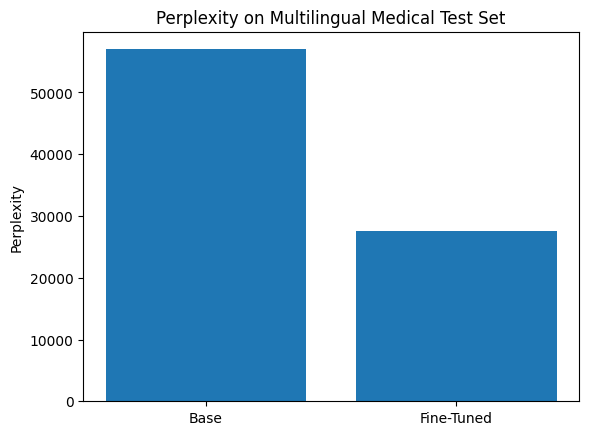

In [ ]:
import matplotlib.pyplot as plt

plt.bar(["Base", "Fine-Tuned"], [base_ppl, ft_ppl])
plt.ylabel("Perplexity")
plt.title("Perplexity on Multilingual Medical Test Set")
plt.savefig("/content/perplexity_comparison.png")
plt.show()
